### Exploring venues in Lucnkow, India

Table of Contents
- Introduction
- Data Collection from APIs
- Data Cleaning
- Methodolgy
- Analysis
- Results and Discussion
- Conclusion

### Introduction 
The aim of the project is to identify venues in Lucknow, India based on their rating and average prices. In this notebook, we will **identify various venues in the city of Lucknow**, India, using **Foursquare API and Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

### Data Collection from APIs 
To begin with, we will take a look at Lucknow on the Map using the folium library.

We will also fetch the data from two different APIs.

**Foursquare API**: We will use the Foursquare API to fetch venues in Lucknow starting from the middle upto 10 Kilometers in each direction.
**Zomato API**: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Lucknow
**Lucknow** is composed of a number of sectors spread across a total area of 349 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We can use the geopy library to extract the latitude and longitude values of Lucknow but it seems off and thus, we'll directly supply the values in this case.

In [148]:
LKO_LATITUDE = '26.8467'
LKO_LONGITUDE = '80.9462'
print('The geograpical coordinates of Lucknow are {}, {}.'.format(LKO_LATITUDE, LKO_LONGITUDE))

The geograpical coordinates of Lucknow are 26.8467, 80.9462.


In [149]:
import folium

lucknow_map = folium.Map(location = [LKO_LATITUDE, LKO_LONGITUDE], zoom_start = 13)
folium.Marker([LKO_LATITUDE, LKO_LONGITUDE]).add_to(lucknow_map)
lucknow_map.save("../Map/lucknow Map.html")
lucknow_map

### Foursquare API

We begin by fetching a total of all venues in Lucknow upto a range of 10 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [2]:
# FOURSQUARE_CLIENT_ID = #CLIENT ID
# FOURSQUARE_CLIENT_SECRET = #CLIENT SECRET
# RADIUS = 10000 # 
# NO_OF_VENUES = 100
# VERSION = '20200105' # Current date

In [151]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 66 venues fetched within a total radius of 10.0 Km

Total 66 venues fetched


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

- The query will be the name of the venue.
- The start defines from what offset we want to start, so we'll keep it at 0.
- The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- We will supply the latitude and longitude values.
- We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [153]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

### Data Cleaning 
The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [154]:
lucknow_map = folium.Map(location = [LKO_LATITUDE, LKO_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(lucknow_map)  

lucknow_map.save("../Map/Venues by Foursquare.html")
lucknow_map

From the map, we can infer that there are clusters of venues around **Sahara Mall, Hajaratganj and lohia park** . We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [155]:
lucknow_map = folium.Map(location = [LKO_LATITUDE, LKO_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(lucknow_map)  

lucknow_map.save("../Map/Venues by Zomato.html")
lucknow_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near **Sahara Mall, Hajaratganj and lohia park**. However, there are others where the data does not match just like the red dots in the top right on the second map (like area near Hasanganj,Vijaykhand)

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [156]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [157]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [158]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Royal Sky,Indian Restaurant,26.8502,80.9410,Royal Sky,26.8504,80.9411,1100.0,3.0,4.3,"Opposite Halwasiya Market Hazratganj, Hazratga...",0.0002,0.0001
1,The Mughal's Dastarkhwan,Indian Restaurant,26.8442,80.9403,The Mughal's Dastarkhwan,26.8442,80.9403,800.0,3.0,4.4,"29, BN Road, Near Royal Hotel Crossing, Lalbag...",0.0000,0.0000
2,Dastarkhwan,Indian Restaurant,26.8527,80.9369,Dastarkhwan,26.8526,80.9368,600.0,2.0,4.5,"20, Wala Qadar Road, DM Compound Colony, Kaise...",-0.0001,-0.0001
3,Hazratganj | हज़रतगंज | حضرتگںج (Hazratganj),Neighborhood,26.8483,80.9448,Madras Restaurant,26.8484,80.9448,200.0,1.0,3.6,"Near Gandhi Ashram, Behind Amar Fax, Hazratgan...",0.0001,0.0000
4,Cappuccino Blast,Café,26.8337,80.9477,Cappuccino Blast,26.8337,80.9478,700.0,2.0,4.3,"12, Mall Avenue, Near, Hazratganj, Lucknow",0.0000,0.0001
5,Janpath Market,Shopping Mall,26.8468,80.9437,Quality Like Five Star,26.8469,80.9438,300.0,1.0,3.0,"A 21, Janpath Market, Off MG Marg, Lalbagh, Lu...",0.0001,0.0001
6,JJ Bakery,Bakery,26.8727,80.9411,La Reine,26.8729,80.9411,500.0,2.0,3.3,"Shop No-UGF-1,Shree Plaza Complex,Vikas Nagar,...",0.0002,0.0000
7,Moti Mahal,Indian Restaurant,26.8474,80.9453,Moti Mahal Sweets,26.8472,80.9453,400.0,2.0,3.4,"75, Mahatma Gandhi Marg, Next To Central Bank ...",-0.0002,0.0000
8,Royal Cafe,Fast Food Restaurant,26.8483,80.9439,Royal Cafe,26.8482,80.9439,800.0,3.0,4.3,"51, Opposite Sahu Cinema, MG Marg, Hazratganj,...",-0.0001,0.0000
9,Chappan bhog,Fast Food Restaurant,26.8276,80.9449,South Indian Raman Dosa,26.8276,80.9450,300.0,1.0,3.4,"Near Chhappan Bhog, Sadar Bazaar, Lucknow.",0.0000,0.0001


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1**: There are venues that have specific restaurants/cafes inside them as provided by Zomato API (Quality Like Five Star in Shopping Mall ,Janpath Market).


**Category 2**: Some have been replaced with new restaurants (JJ Bakery has now been replaced by La Reine).

The venues which belong to category 1 and category 32 are alright to keep.

I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [159]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [160]:
selected_venues.head(10)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Royal Sky,26.8504,80.9411,3.0,4.3,"Opposite Halwasiya Market Hazratganj, Hazratga...",550.0
1,Indian Restaurant,The Mughal's Dastarkhwan,26.8442,80.9403,3.0,4.4,"29, BN Road, Near Royal Hotel Crossing, Lalbag...",400.0
2,Indian Restaurant,Dastarkhwan,26.8526,80.9368,2.0,4.5,"20, Wala Qadar Road, DM Compound Colony, Kaise...",300.0
3,Neighborhood,Madras Restaurant,26.8484,80.9448,1.0,3.6,"Near Gandhi Ashram, Behind Amar Fax, Hazratgan...",100.0
4,Café,Cappuccino Blast,26.8337,80.9478,2.0,4.3,"12, Mall Avenue, Near, Hazratganj, Lucknow",350.0
5,Shopping Mall,Quality Like Five Star,26.8469,80.9438,1.0,3.0,"A 21, Janpath Market, Off MG Marg, Lalbagh, Lu...",150.0
6,Bakery,La Reine,26.8729,80.9411,2.0,3.3,"Shop No-UGF-1,Shree Plaza Complex,Vikas Nagar,...",250.0
7,Indian Restaurant,Moti Mahal Sweets,26.8472,80.9453,2.0,3.4,"75, Mahatma Gandhi Marg, Next To Central Bank ...",200.0
8,Fast Food Restaurant,Royal Cafe,26.8482,80.9439,3.0,4.3,"51, Opposite Sahu Cinema, MG Marg, Hazratganj,...",400.0
9,Fast Food Restaurant,South Indian Raman Dosa,26.8276,80.9450,1.0,3.4,"Near Chhappan Bhog, Sadar Bazaar, Lucknow.",150.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [134]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 34


### Methodology 

This project aims at identifying the venues in Lucnkow based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extract venue information from the center of Lucknow, upto a distance of 10 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then **explored the data** retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll **analyse the data** that we created based on the ratings and price of each venue. We'll **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore **areas that are high rated** and those that are low rated while also plotting the map of **high and low priced venues** . Lastly, we'll **cluster the venues** based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

### Analysis 
The complete dataset is now in its final form.

We will inspect these **venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**.

### Categories
We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 13 artists>

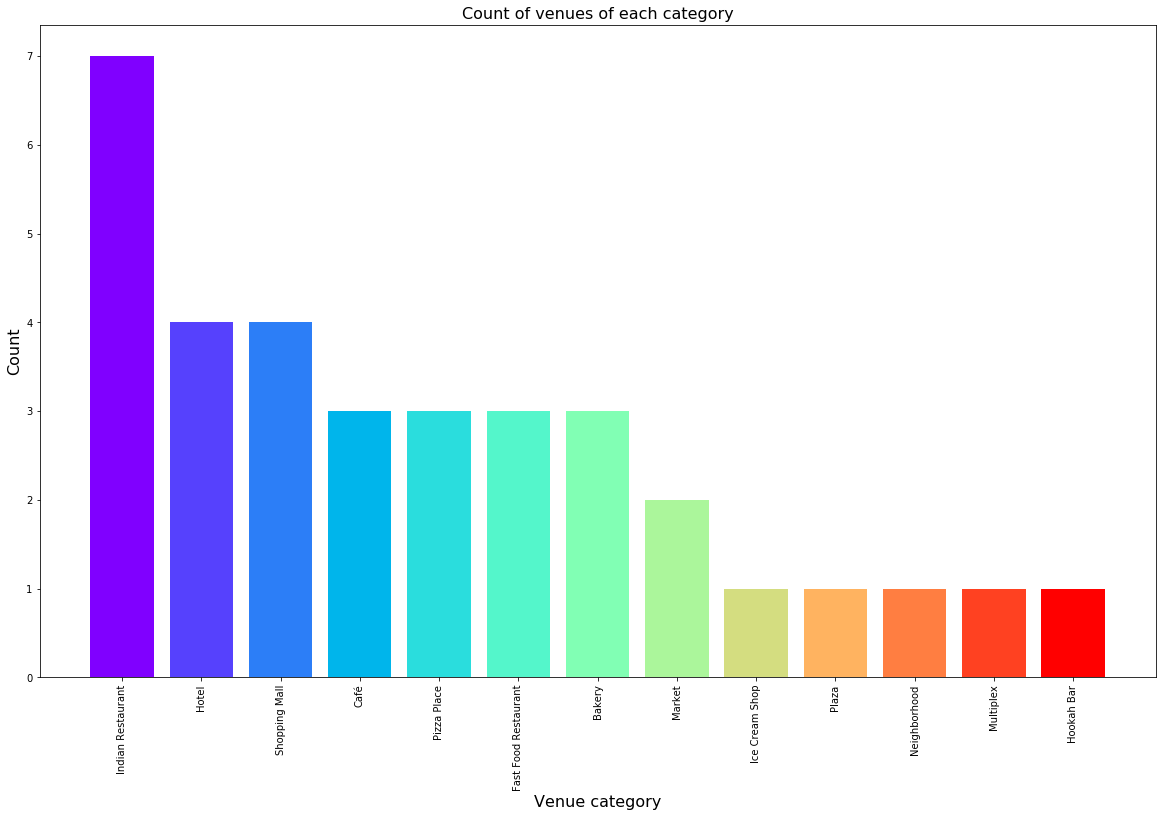

In [135]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Cafe and Indian Restaurant. So, if as a tourist, you're looking for  **Indian restaurants and Shopping Mall**, you're in luck.

### Rating
Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

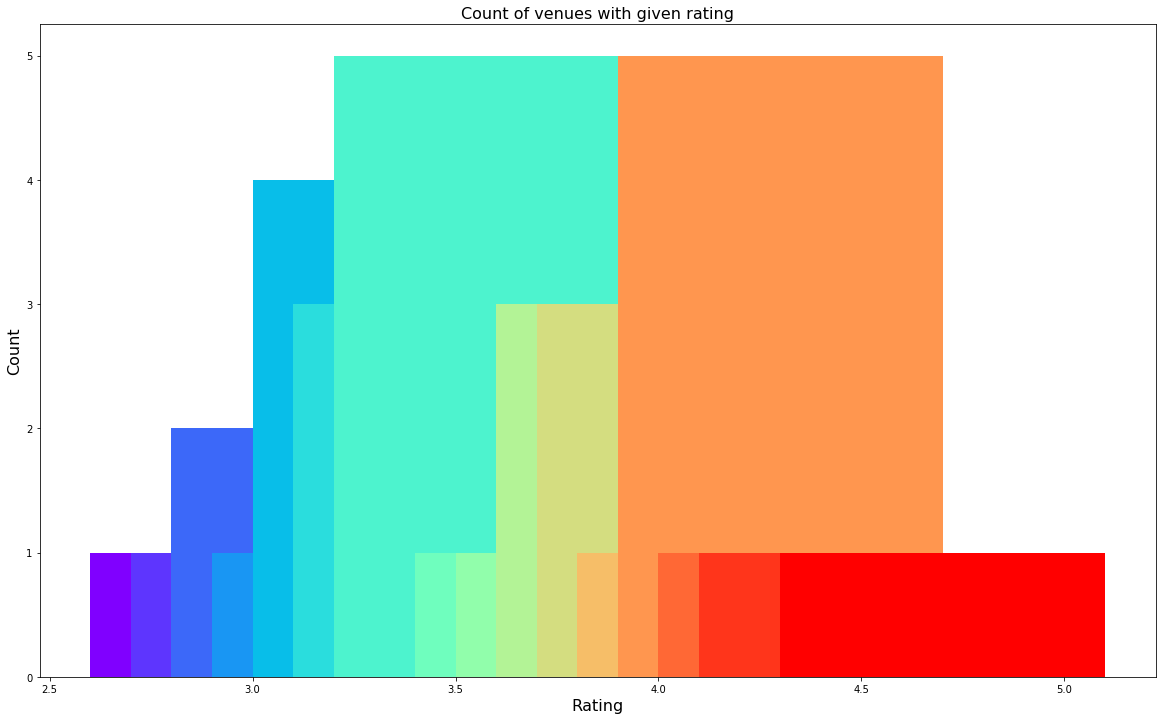

In [136]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [137]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [138]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

lucknow_map = folium.Map(location = [LKO_LATITUDE, LKO_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(lucknow_map)  

lucknow_map.save("../Map/Venues Ratings.html")
lucknow_map

The map has the location of all the venues. It appears that many venues are located near about **Hajaratganj, Gomati nagar and Saharaganj Mall** with rating above 3. If someone wants to explore new venues, they should definitely check out **Hajaratganj, Gomati nagar and Saharaganj Mall** .

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

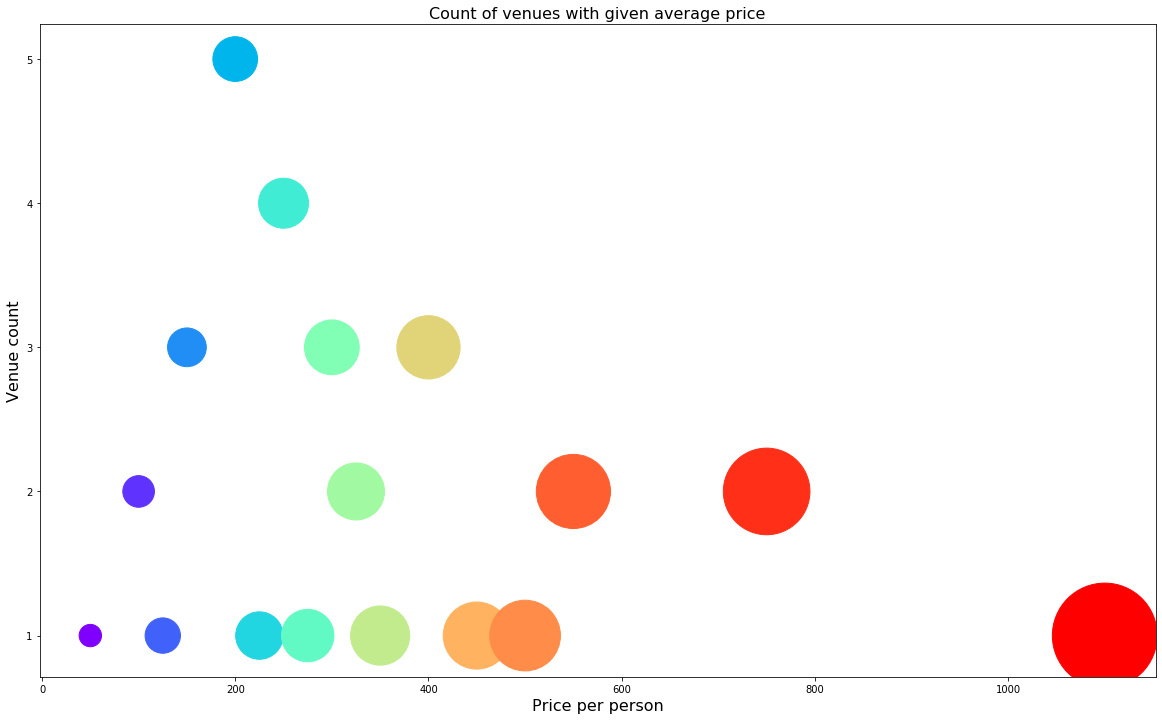

In [139]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)


From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 450.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [140]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("../Map/Venues Prices.html")
chandigarh_map

- The venues near Lohia Park are primarily Higher priced.
- The venues near Gomati Nagar have steep prices.
- Hajarathganj and Saharaganj mall seems to have a mix of both moderate priced and low priced venues.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [141]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Royal Sky,26.8504,80.9411,3.0,4.3,"Opposite Halwasiya Market Hazratganj, Hazratga...",550.0,Very good
1,1,Indian Restaurant,The Mughal's Dastarkhwan,26.8442,80.9403,3.0,4.4,"29, BN Road, Near Royal Hotel Crossing, Lalbag...",400.0,Very good
2,1,Indian Restaurant,Dastarkhwan,26.8526,80.9368,2.0,4.5,"20, Wala Qadar Road, DM Compound Colony, Kaise...",300.0,Very good
3,1,Neighborhood,Madras Restaurant,26.8484,80.9448,1.0,3.6,"Near Gandhi Ashram, Behind Amar Fax, Hazratgan...",100.0,Good
4,1,Café,Cappuccino Blast,26.8337,80.9478,2.0,4.3,"12, Mall Avenue, Near, Hazratganj, Lucknow",350.0,Very good


In [142]:
lucknow_map = folium.Map(location = [LKO_LATITUDE, LKO_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(lucknow_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(lucknow_map)

lucknow_map.save("../Map/Venues Clusters.html")
lucknow_map

From the map, we see the two clusters:

- The first cluster is spread across the whole city and includes the majority venues.
- The second cluster is very sparsely spread and has very limited venues.

I'll also check the venues of the two clusters.

In [143]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Royal Sky,26.8504,80.9411,3.0,4.3,"Opposite Halwasiya Market Hazratganj, Hazratga...",550.0,Very good
1,0,Hookah Bar,Blue The Lounge,26.8538,80.9453,3.0,3.6,"1A, Shravan Plaza Complex, Sapru Marg, Hazratg...",500.0,Good
2,0,Shopping Mall,Ttamaasha Bistro Bar,26.8701,80.9971,4.0,4.0,"Wave Mall, 4th Floor, Gomti Nagar, Lucknow",1100.0,Good
3,0,Hotel,Kava Restaurant - Fairfield by Marriott,26.8678,81.0095,4.0,4.0,"Gate 2, Opposite Indra Gandhi Prathishthan, Vi...",750.0,Good
4,0,Hotel,Azure - Casaya Inn,26.8532,81.0263,4.0,3.5,"CP - 128, Casaya Inn, Opposite Door Darshan Co...",750.0,Good
5,0,Hotel,Urban Terrace,26.8519,81.0233,3.0,4.1,"Hotel Lineage CP-73, Viraj Khand,Gomtinagar,Ne...",550.0,Very good


In [144]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 3.50 and rating spread around 3.92


In [145]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,The Mughal's Dastarkhwan,26.8442,80.9403,3.0,4.4,"29, BN Road, Near Royal Hotel Crossing, Lalbag...",400.0,Very good
1,1,Indian Restaurant,Dastarkhwan,26.8526,80.9368,2.0,4.5,"20, Wala Qadar Road, DM Compound Colony, Kaise...",300.0,Very good
2,1,Neighborhood,Madras Restaurant,26.8484,80.9448,1.0,3.6,"Near Gandhi Ashram, Behind Amar Fax, Hazratgan...",100.0,Good
3,1,Café,Cappuccino Blast,26.8337,80.9478,2.0,4.3,"12, Mall Avenue, Near, Hazratganj, Lucknow",350.0,Very good
4,1,Shopping Mall,Quality Like Five Star,26.8469,80.9438,1.0,3.0,"A 21, Janpath Market, Off MG Marg, Lalbagh, Lu...",150.0,Okay
5,1,Bakery,La Reine,26.8729,80.9411,2.0,3.3,"Shop No-UGF-1,Shree Plaza Complex,Vikas Nagar,...",250.0,Good
6,1,Indian Restaurant,Moti Mahal Sweets,26.8472,80.9453,2.0,3.4,"75, Mahatma Gandhi Marg, Next To Central Bank ...",200.0,Good
7,1,Fast Food Restaurant,Royal Cafe,26.8482,80.9439,3.0,4.3,"51, Opposite Sahu Cinema, MG Marg, Hazratganj,...",400.0,Very good
8,1,Fast Food Restaurant,South Indian Raman Dosa,26.8276,80.9450,1.0,3.4,"Near Chhappan Bhog, Sadar Bazaar, Lucknow.",150.0,Good
9,1,Indian Restaurant,Royal Hut,26.8560,80.9453,1.0,3.2,"9/7, Shahnajaf Road, Hazratganj, Lucknow",125.0,Good


In [146]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.89 and rating spread around 3.77


### Results and Discussion 

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Lucnkow, India.

After collecting data from the **Foursquare and Zomato APIs**, we got a list of 66 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 34.

We identified that from the total set of venues, majority of them were **Indian Restaurants, Hotels and shopping mall**. A visitor who loves Indian Restaurants and shopping mall would surely benefit from coming to Lucnkow.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food which** is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Hajaratganj, Gomati Nagar and Saharaganj Mall**. These clusters also have very **high ratings (more than 3)**.

When we take a look at the price values of each venue, we explore that many venues have **prices which are in the range of Rs 200 to Rs 450 for one person**. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near **Hajarathganj and Saharaganj are relatively priced lower than venues in Lohia park and Gomati nagar**. A mix of **low price and high price exist in Sahara ganj Mall**.

Finally, through clusters we identified that there are **many venues which are relatively lower priced** but have an **average rating of 3.77**. On the other hand, there are few venues which are **high priced and have average rating of 3.92**.

- If you're looking for cheap places with relatively high rating, you should check **Hajarathganj**.
- If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit **Lohia park and Gomati Nagar**.
- If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try **Saharaganj Mall**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

### Conclusion 

The purpose of this project was to explore the places that a person visiting Lucknow could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are four major areas a person can visit: Hajarathganj, Lohia park,Gomati Nagar and Saharaganj Mall. Based on the visitor's venue rating and price requirements, he/she can choose amongst the four places.